In [1]:
# This notebook applies SHAP (SHapley Additive exPlanations) to interpret
# the best-performing machine-learning model used to predict serious
# psychological distress (K6SPD_A) in the NHIS 2021–2023 dataset.
# SHAP is used to enhance transparency and explainability of model predictions.

import pandas as pd
import numpy as np
import shap
import joblib
import matplotlib.pyplot as plt


In [ ]:
# This cell loads the combined NHIS dataset and the best-performing
# trained model pipeline saved during the modelling stage.

import os
combined_local = 'nhis_2021_2023_combined.csv'
combined_onedrive = os.path.join(os.path.expanduser('~'), 'OneDrive', 'Documents', 'CSST MASTERS PROJECT', 'nhis_2021_2023_combined.csv')
if os.path.exists(combined_local):
    df = pd.read_csv(combined_local)
    print(f'Loaded df from {combined_local}')
elif os.path.exists(combined_onedrive):
    df = pd.read_csv(combined_onedrive)
    print(f'Loaded df from {combined_onedrive}')
else:
    raise FileNotFoundError('nhis_2021_2023_combined.csv not found in workspace or OneDrive CSST MASTERS PROJECT folder')
model = joblib.load("best_model_pipeline_k6spd.joblib")

print("Dataset shape:", df.shape)
print("Model loaded:", model)


Dataset shape: (86655, 821)
Model loaded: Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['AGEP_A', 'SEX_A', 'REGION',
                                                   'URBRRL', 'RACEALLP_A',
                                                   'HISP_A', 'EDUCP_A',
                                                   'MARITAL_A', 'PHSTAT_A',
                                                   'HYPEV_A', 'CHLEV_A',
                                                   'DIBEV_A', 'ARTHEV_A',
                                                   'COPDEV_A', 'COVER_A',
 

In [3]:
# This cell defines the target variable and applies the same
# binary mapping used during model training.

TARGET = "K6SPD_A"

def nhis_yesno_to_binary(x):
    if x == 1: return 1
    if x == 2: return 0
    return np.nan

df["_target_bin"] = df[TARGET].apply(nhis_yesno_to_binary)
df = df[df["_target_bin"].notna()].copy()
df["_target_bin"] = df["_target_bin"].astype(int)

df["_target_bin"].value_counts()


_target_bin
0    27599
1     1012
Name: count, dtype: int64

In [4]:
# This cell reconstructs the feature matrix using the same
# predictors used during model training.

predictors = [
    "AGEP_A", "SEX_A", "REGION", "URBRRL",
    "RACEALLP_A", "HISP_A", "EDUCP_A", "MARITAL_A",
    "PHSTAT_A", "HYPEV_A", "CHLEV_A", "DIBEV_A",
    "ARTHEV_A", "COPDEV_A",
    "COVER_A", "NOTCOV_A",
    "SRVY_YR"
]

predictors = [c for c in predictors if c in df.columns]
X = df[predictors].copy()

X.shape


(28611, 17)

In [5]:
# This cell applies the preprocessing step of the trained pipeline
# to transform raw features into the model-ready format required by SHAP.

preprocess = model.named_steps["preprocess"]
X_processed = preprocess.transform(X)

X_processed.shape


(28611, 17)

In [6]:
# This cell extracts the final estimator from the trained pipeline.
# Tree-based models are best explained using TreeExplainer.

final_model = model.named_steps["model"]
type(final_model)


sklearn.ensemble._gb.GradientBoostingClassifier

In [7]:
# This cell creates a SHAP explainer suitable for tree-based models.
# SHAP values quantify each feature's contribution to model predictions.

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_processed)


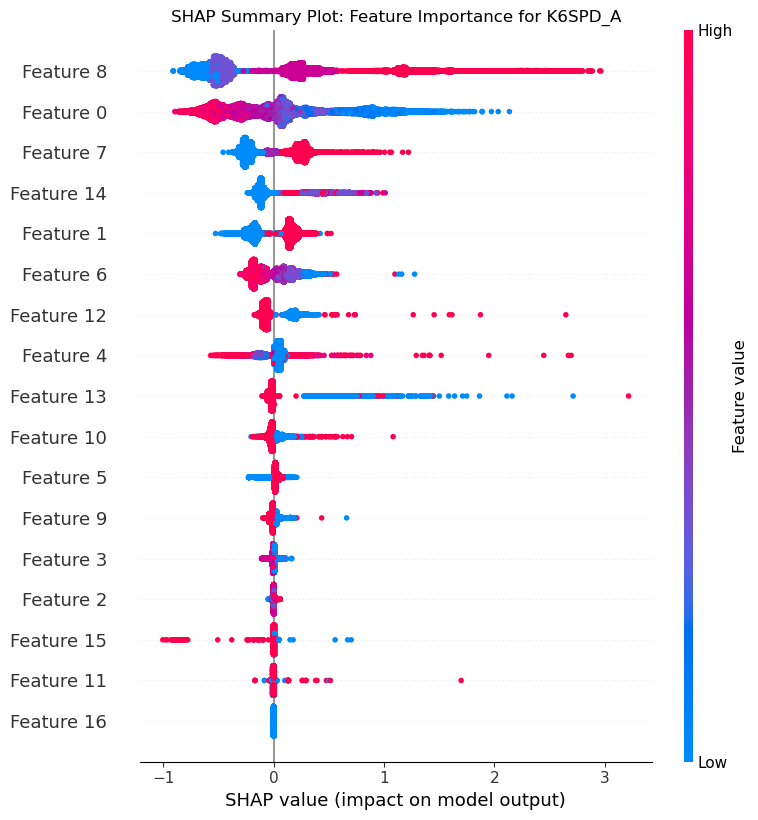

In [8]:
# This cell generates a global SHAP summary plot.
# It shows which features contribute most to predicting K6SPD_A
# across the entire population.

shap.summary_plot(
    shap_values,
    X_processed,
    show=False
)

plt.title("SHAP Summary Plot: Feature Importance for K6SPD_A")
plt.tight_layout()
plt.savefig("fig_shap_summary_k6spd.png", dpi=300, bbox_inches="tight")
plt.show()


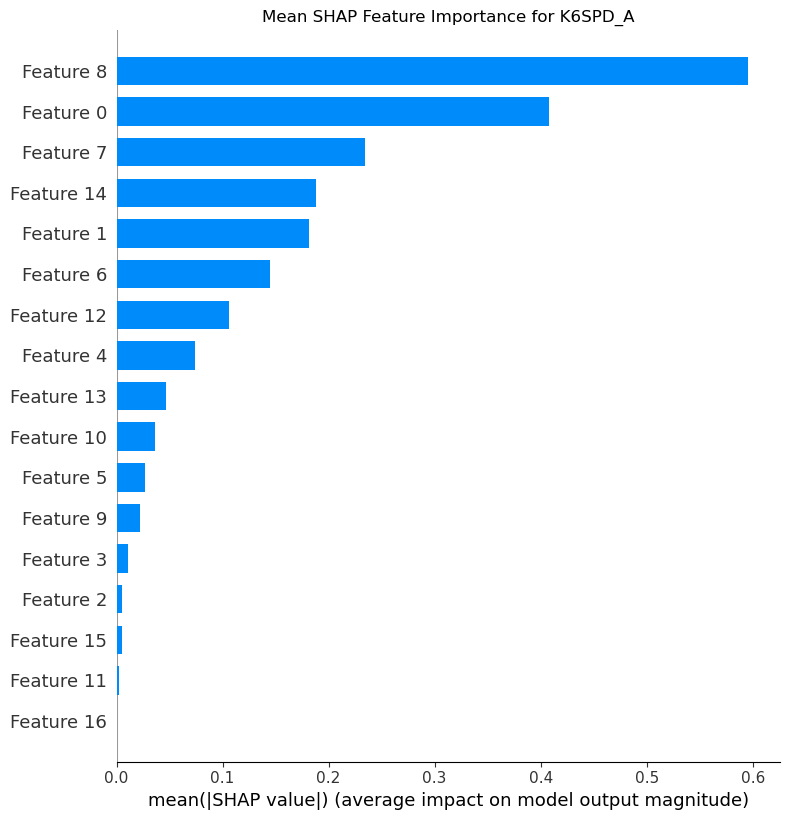

In [9]:
# This cell produces a SHAP bar plot showing average absolute
# feature importance across the dataset.

shap.summary_plot(
    shap_values,
    X_processed,
    plot_type="bar",
    show=False
)

plt.title("Mean SHAP Feature Importance for K6SPD_A")
plt.tight_layout()
plt.savefig("fig_shap_bar_k6spd.png", dpi=300, bbox_inches="tight")
plt.show()


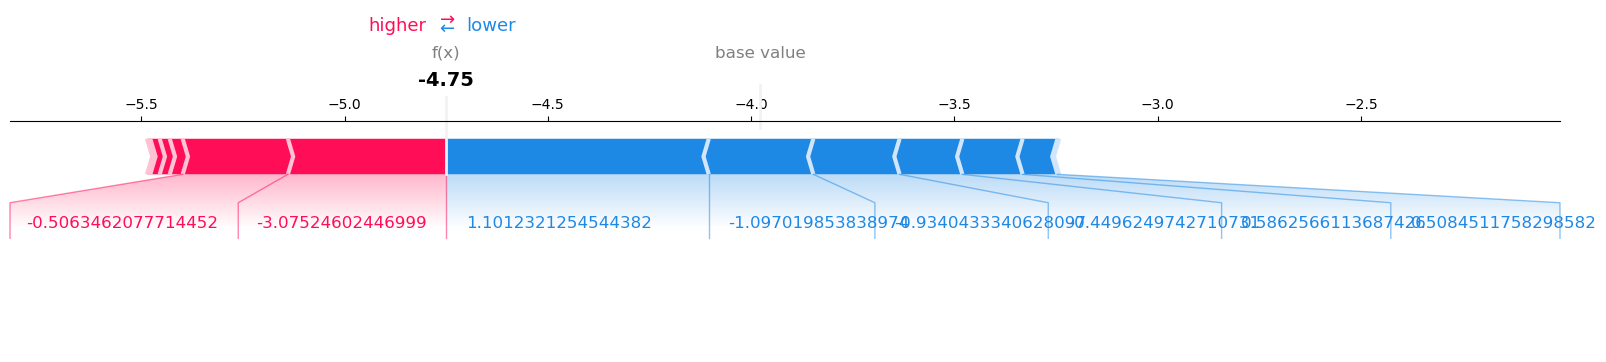

<Figure size 640x480 with 0 Axes>

In [10]:
# This cell provides a local SHAP explanation for one randomly
# selected individual, illustrating how the model arrived at a prediction.

idx = np.random.randint(0, X_processed.shape[0])

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_processed[idx],
    matplotlib=True
)

plt.savefig("fig_shap_local_example_k6spd.png", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
# This cell saves SHAP values for potential use in the interactive dashboard.

shap_df = pd.DataFrame(
    shap_values,
    columns=[f"SHAP_{i}" for i in range(shap_values.shape[1])]
)

shap_df.to_csv("shap_values_k6spd.csv", index=False)
print("Saved: shap_values_k6spd.csv")


Saved: shap_values_k6spd.csv
